# U-Net - Modified

## Import libraries

In [ ]:
from google.colab.patches import cv2_imshow
from matplotlib.style import use
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import tensorflow as tf

use('seaborn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.9.2


## Get datasets

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'gabevr'
os.environ['KAGGLE_KEY'] = 'ca479e66ac6ae221b62be68f056aca65'

In [ ]:
!kaggle competitions download -c data-science-bowl-2018

100% 358M/358M [00:20<00:00, 20.5MB/s]
100% 358M/358M [00:20<00:00, 18.6MB/s]


In [ ]:
!unzip data-science-bowl-2018.zip

Archive:  data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [ ]:
!unzip stage1_train.zip -d /content/training/
!unzip stage1_test.zip -d /content/testing/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/training/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d86ee01921b1c9ed23c342952253682060512483c39c8b7b5c6d8350f6df2568.png  
  inflating: /content/training/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d8b76279ad8f2e101bb8c5ca95229b6532903eea035ef945dd4a21356d49dead.png  
  inflating: /content/training/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/dc05f946c096c5fcc147024843f21c06c3a94af25d4f37b498ea937953b806fe.png  
  inflating: /content/training/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e0fd1c4e98bb470bea315e7d8f74396450fe93e93f68e1f8a3443b2b397c8640.png  
  inflating: /content/training/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e4b6643cafde8ac789b63f7b1a023773960dbe63489963985033619fde052dc9.png  
  inflating: /content/training/d52958107d0b1f0288f50f346a833df3df485b92d5516

In [ ]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3

SEED = 42
np.random.seed = SEED
random.seed = SEED

TRAINING_FILEPATH = '/content/training'
TESTING_FILEPATH = '/content/testing'

In [ ]:
training_images_identifier = next(os.walk(TRAINING_FILEPATH))[1]
testing_images_identifier = next(os.walk(TESTING_FILEPATH))[1]

print(f'Training images identifier length: {len(training_images_identifier)}')
print(f'Testing images identifier length: {len(testing_images_identifier)}')

Training images identifier length: 670
Testing images identifier length: 65


In [ ]:
training_dataset = np.ones((len(training_images_identifier), HEIGHT, WIDTH, CHANNELS), dtype=np.uint8)
training_masks = np.ones((len(training_images_identifier), HEIGHT, WIDTH, 1), dtype=bool)

print(f'Training datast shape: {training_dataset.shape}')
print(f'Training masks shape: {training_masks.shape}')

Training datast shape: (670, 256, 256, 3)
Training masks shape: (670, 256, 256, 1)


In [ ]:
testing_dataset = np.ones((len(testing_images_identifier), HEIGHT, WIDTH, CHANNELS), dtype=np.uint8)

print(f'Testing datast shape: {testing_dataset.shape}')


Testing datast shape: (65, 256, 256, 3)


## Pre-processing.

In [ ]:
for n, id_, in tqdm(enumerate(training_images_identifier), total=len(training_images_identifier)):
  image_directorypath = f'{TRAINING_FILEPATH}/{id_}'
  image_filepath = f'{image_directorypath}/images/{id_}.png'
  
  if "." in image_directorypath:
    continue

  image = cv2.imread(image_filepath)[:,:,:CHANNELS]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (HEIGHT, WIDTH))
  training_dataset[n] = image

  image_mask = np.zeros((HEIGHT, WIDTH, 1), dtype=bool)

  for mask_file in next(os.walk(f'{image_directorypath}/masks/'))[2]:
    image_mask_ = cv2.imread(f'{image_directorypath}/masks/{mask_file}')
    image_mask_ = cv2.cvtColor(image_mask_, cv2.COLOR_BGR2GRAY)
    image_mask_ = np.expand_dims(cv2.resize(image_mask_,(HEIGHT, WIDTH)), axis=-1)
    image_mask = np.maximum(image_mask, image_mask_)

  training_masks[n] = image_mask

100%|██████████| 670/670 [00:47<00:00, 13.97it/s]


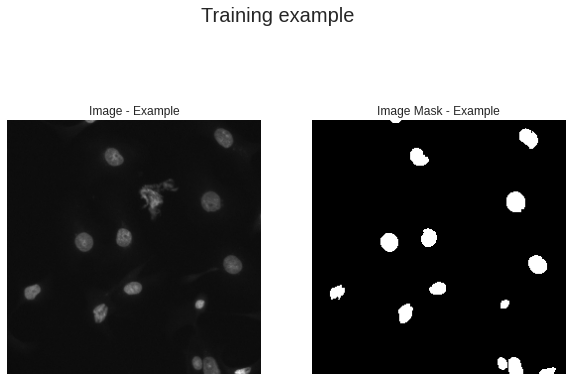

In [ ]:
figure = plt.figure(figsize=(10, 7))
figure.suptitle("Training example", size=20)

figure.add_subplot(1,2,1)
plt.imshow(training_dataset[0])
plt.axis("off")
plt.title("Image - Example")

figure.add_subplot(1,2,2)
plt.imshow(np.squeeze(training_masks[0]), cmap="gray")
plt.axis("off")
plt.title("Image Mask - Example")

plt.show()

In [ ]:
for n, id_, in tqdm(enumerate(testing_images_identifier), total=len(testing_images_identifier)):
  image_directorypath = f'{TESTING_FILEPATH}/{id_}'
  image_filepath = f'{image_directorypath}/images/{id_}.png'
  
  if "." in image_directorypath:
    continue

  image = cv2.imread(image_filepath)[:,:,:CHANNELS]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (HEIGHT, WIDTH))
  testing_dataset[n] = image

100%|██████████| 65/65 [00:00<00:00, 184.70it/s]


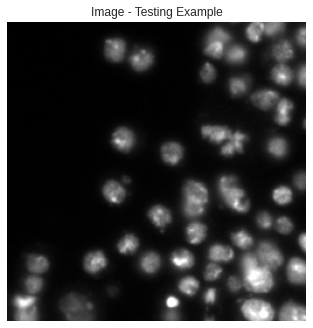

In [ ]:
plt.imshow(testing_dataset[0])
plt.axis("off")
plt.title("Image - Testing Example")
plt.show()

## Training and validation dataset split.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(training_dataset, training_masks, test_size=0.10, random_state=42)

print(f'Training datast shape: {X_train.shape} ----- {y_train.shape}')
print(f'Validation datast shape: {X_valid.shape} ----- {y_valid.shape}')

Training datast shape: (603, 256, 256, 3) ----- (603, 256, 256, 1)
Validation datast shape: (67, 256, 256, 3) ----- (67, 256, 256, 1)


## Build the model

### Convolutional block function

In [ ]:
def conv_block(input, n_filters):
  x = tf.keras.layers.Conv2D(n_filters, 3, padding="same")(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)

  x = tf.keras.layers.Conv2D(n_filters, 3, padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)

  return x

### Encoder block function

In [ ]:
def encoder_block(input, n_filters):
  x = conv_block(input, n_filters)
  p = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

  return x, p

### Decoder block function

In [ ]:
def decoder_block(input, skip_features, n_filters):
  x = tf.keras.layers.Conv2DTranspose(n_filters, (2,2), strides=2, padding="same")(input)
  x = tf.keras.layers.Concatenate()([x, skip_features])
  x = conv_block(x, n_filters)
  
  return x

### U-Net model.

In [ ]:
def unet_model(input_shape):
  inputs = tf.keras.layers.Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)
  
  b1 = conv_block(p4, 1024)
  
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  output = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

  model = tf.keras.models.Model(inputs, output, name="U-Net")
  return model

In [ ]:
model = unet_model((HEIGHT, WIDTH, CHANNELS))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])
print(model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model_filename = 'unet.json'
json_model = model.to_json()
with open(model_filename, 'w') as json_file:
  json_file.write(json_model)

## Callbacks

In [ ]:
model_name = 'unet_model.h5'
checkpointer = tf.keras.callbacks.ModelCheckpoint(model_name, verbose=1, save_best_only=True)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

callbacks = [checkpointer, early_stopper]

In [ ]:
EPOCHS = 15
BATCH_SIZE = 8

In [ ]:
history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, 
                    validation_data=(X_valid, y_valid))

Epoch 1/15
76/76 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8723
Epoch 1: val_loss improved from inf to 0.47124, saving model to unet_model.h5
76/76 [==============================] - 61s 579ms/step - loss: 0.3909 - accuracy: 0.8723 - val_loss: 0.4712 - val_accuracy: 0.9233
Epoch 2/15
76/76 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9576
Epoch 2: val_loss improved from 0.47124 to 0.28809, saving model to unet_model.h5
76/76 [==============================] - 42s 550ms/step - loss: 0.2105 - accuracy: 0.9576 - val_loss: 0.2881 - val_accuracy: 0.9448
Epoch 3/15
76/76 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9643
Epoch 3: val_loss improved from 0.28809 to 0.17960, saving model to unet_model.h5
76/76 [==============================] - 43s 570ms/step - loss: 0.1665 - accuracy: 0.9643 - val_loss: 0.1796 - val_accuracy: 0.9631
Epoch 4/15
76/76 [==============================] - ETA: 0s - loss: 0.1449 - acc

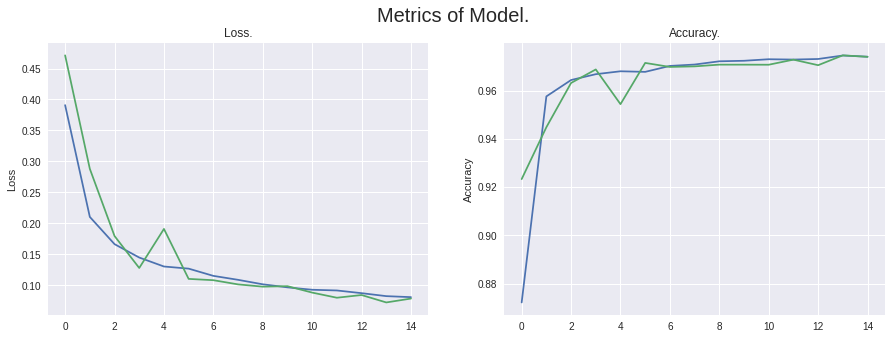

In [ ]:
figure = plt.figure(figsize=(15, 5))
figure.suptitle('Metrics of Model.', size=20)

figure.add_subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss.')

figure.add_subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy.')

plt.show()

## Validation images.

In [ ]:
validation_predictions = model.predict(X_valid)
print(f'Predicitions shape: {validation_predictions.shape}')

3/3 [==============================] - 1s 532ms/step
Predicitions shape: (67, 256, 256, 1)


In [ ]:
validation_predictions = (validation_predictions > 0.5).astype(np.uint8)
print(f'Predicitions shape: {validation_predictions.shape}')

Predicitions shape: (67, 256, 256, 1)


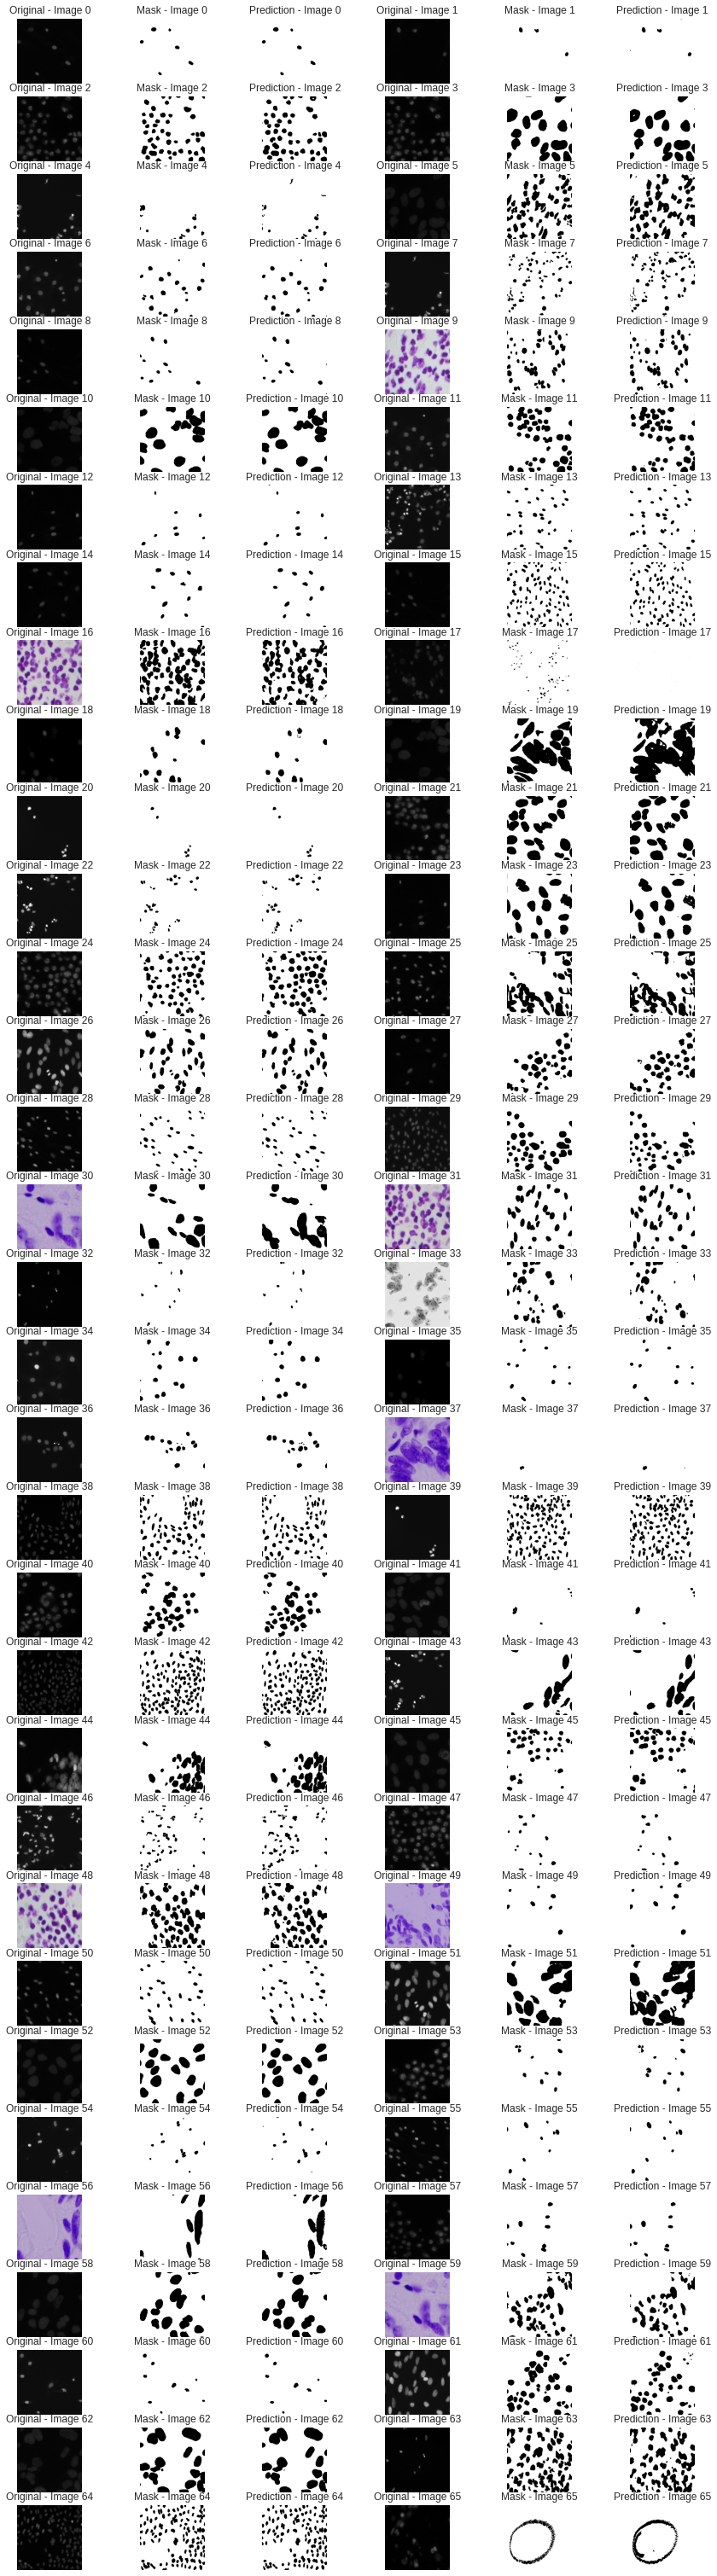

In [ ]:
N_VALIDATION_PREDICTIONS = validation_predictions.shape[0]
N_COLS = 6
N_ROWS = int(N_VALIDATION_PREDICTIONS / 2)
image_identifier = 0
index_subplot = 1

figure = plt.figure(figsize=(15, 55))

for i in range(N_ROWS):
  figure.add_subplot(N_ROWS, N_COLS, index_subplot)
  plt.imshow(X_valid[image_identifier])
  plt.axis('off')
  plt.title(f'Original - Image {image_identifier}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 1)
  plt.imshow(np.squeeze(y_valid[image_identifier]))
  plt.axis('off')
  plt.title(f'Mask - Image {image_identifier}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 2)
  plt.imshow(np.squeeze(validation_predictions[image_identifier]))
  plt.axis('off')
  plt.title(f'Prediction - Image {image_identifier}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 3)
  plt.imshow(X_valid[i + 1])
  plt.axis('off')
  plt.title(f'Original - Image {image_identifier + 1}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 4)
  plt.imshow(np.squeeze(y_valid[image_identifier + 1]))
  plt.axis('off')
  plt.title(f'Mask - Image {image_identifier + 1}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 5)
  plt.imshow(np.squeeze(validation_predictions[image_identifier + 1]))
  plt.axis('off')
  plt.title(f'Prediction - Image {image_identifier + 1}')
  
  index_subplot +=  6
  image_identifier += 2

plt.show()

## Test images.

In [ ]:
test_predictions = model.predict(testing_dataset)
print(f'Test predicitions shape: {test_predictions.shape}')

3/3 [==============================] - 1s 535ms/step
Test predicitions shape: (65, 256, 256, 1)


In [ ]:
test_predictions = (test_predictions >= 0.5).astype(np.uint8)
print(f'Test predicitions shape: {test_predictions.shape}')

Test predicitions shape: (65, 256, 256, 1)


In [ ]:
N_TEST_PREDICTIONS = test_predictions.shape[0]
N_COLS = 6
N_ROWS = int(N_TEST_PREDICTIONS / 3)
image_identifier = 0
index_subplot = 1

figure = plt.figure(figsize=(15, 55))

for i in range(N_ROWS):
  figure.add_subplot(N_ROWS, N_COLS, index_subplot)
  plt.imshow(testing_dataset[image_identifier])
  plt.axis('off')
  plt.title(f'Original - Image {image_identifier}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 1)
  plt.imshow(np.squeeze(test_predictions[image_identifier]))
  plt.axis('off')
  plt.title(f'Prediction Mask - Image {image_identifier}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 2)
  plt.imshow(testing_dataset[image_identifier + 1])
  plt.axis('off')
  plt.title(f'Original - Image {image_identifier + 1}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 3)
  plt.imshow(np.squeeze(test_predictions[image_identifier + 1]))
  plt.axis('off')
  plt.title(f'Prediction Mask - Image {image_identifier + 1}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 4)
  plt.imshow(testing_dataset[image_identifier + 2])
  plt.axis('off')
  plt.title(f'Original - Image {image_identifier + 2}')

  figure.add_subplot(N_ROWS, N_COLS, index_subplot + 5)
  plt.imshow(np.squeeze(test_predictions[image_identifier + 2]))
  plt.axis('off')
  plt.title(f'Prediction Mask - Image {image_identifier + 2}')

  index_subplot +=  6
  image_identifier += 3

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Validation evaluation

In [ ]:
sum_score = 0

for i in range(N_VALIDATION_PREDICTIONS):
  iou = tf.keras.metrics.MeanIoU(num_classes=2)
  iou.update_state(np.squeeze(y_valid[i]), np.squeeze(validation_predictions[i]))
  score = iou.result().numpy()
  sum_score += score

final_score = sum_score / N_VALIDATION_PREDICTIONS
print(f'Validation mean IoU: {final_score:.4f}')

Validation mean IoU: 0.8998
